In [1]:
import pickle
import os
import matplotlib.pyplot as plt
import torch
import torchvision.transforms.functional as TF
import gc
import seaborn as sns

from wsi_image_utils import *
from CODIPAIModel import CODIPAIModel
from matplotlib.colors import *
%matplotlib inline
from torchvision import utils
from torchvision import utils
from torch.autograd import Variable

torch.cuda.empty_cache()
gc.collect()

689

# Loading whole slide image image and trained model

In [2]:
!rm -r ./results # Delete privious results

magnification = 0.625
scale = get_scale_by_magnification(magnification)
tile_size = 20
tile_size_original = int(scale * tile_size)
patch_size = (tile_size_original, tile_size_original) 
    
wsi_images_dir = '/NAS1/HnE_images/original/CODIPAI/brain/TIFF/CODIPAI-BRTU-SS-00004/CODIPAI-BRTU-SS-00004-S-TP-01.tiff'
patch_images_results_dir = './results/patches/'
wsi_images_results_dir = './results/wsi/'

ID = wsi_images_dir.split('/')[-1].split('.')[0]

use_cuda=True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") if use_cuda else "cpu"

model = CODIPAIModel("pan", "efficientnet-b3", in_channels=3, out_classes=1)
model_path = "./checkpoints/epoch=72-step=48764.ckpt"
state_dict = torch.load(model_path)
model.load_state_dict(state_dict['state_dict'], strict=False)


rm: cannot remove './results': No such file or directory


<All keys matched successfully>

# Making segmentation patches

In [3]:

if not os.path.isfile(model_path):
    
    logger.info("Trained model not found: '{}'.".format(trained_model_path)) 

else:   

    logger.info("Processing wsi '{}'".format(ID))

    # check directory to save image-patches
    dir_to_save = "{}/{}".format(patch_images_results_dir, ID)
    if not os.path.exists(dir_to_save):
        os.makedirs("{}/{}".format(wsi_images_results_dir, ID))
        os.makedirs("{}/01-unet_result".format(dir_to_save))

    # scale down image
    pil_scaled_down_image, scale = scale_down_camelyon16_img(wsi_images_dir, magnification)
    np_scaled_down_image = pil_to_np(pil_scaled_down_image)

    # extract tissue region 
    np_tissue_mask, np_masked_image = extract_normal_region_from_wsi(wsi_images_dir, np_scaled_down_image, None)
    pil_masked_image = np_to_pil(np_masked_image)
#     pil_masked_image.save('{}/AAA_2.png'.format('./sourcecode/CAMELYON16'))

    # draw the heat grid
    pil_img_result, heat_grid, number_of_tiles = draw_heat_grid(np_masked_image, tile_size)

    # run the model
    count_tiles = 0
    count_roi_tiles = 0
    for idx, (position, row, column, location, size, color) in enumerate(heat_grid):

        if color != GREEN_COLOR:
            count_tiles += 1
            r_s = row * tile_size
            r_e = r_s + tile_size
            c_s = column * tile_size
            c_e = c_s + tile_size
            np_tile_masked = np_masked_image[r_s:r_e, c_s:c_e]

            # only tile with valid size
            if np_tile_masked.shape[0] == tile_size and np_tile_masked.shape[1] == tile_size:

                # read the tile from the original wsi image
                pil_input_tile, np_input_tile = read_region(wsi_images_dir, column, row, magnification, tile_size)

                X = torch.from_numpy(np_input_tile).permute(2, 0, 1).float().to(device)
                model.to(device)
                X = Variable(X.unsqueeze(0)) if use_cuda else X.unsqueeze(0)

                with torch.no_grad():
                    model.eval()
#                         y_hat = model(X).detach().cpu().squeeze(0)
                    y_hat = model(X.to(device)).detach().cpu().squeeze(0)
                #y_hat = model(X).squeeze(0)
                output_tile = y_hat[0]
                np_output_tile = output_tile.squeeze(0).detach().cpu().numpy()
                #

                # only tiles that something was found by model
                if np.any(np.unique(np_output_tile >= 0.1)):

                    # save the output image-patch results
                    utils.save_image(output_tile, '{}/01-unet_result/{}_r{}c{}.png'.format(dir_to_save, ID, row, column))

                    np_output_tile[np_output_tile > 0] = 1
                    count_roi_tiles += 1

    logger.info("\t '{}/{}/{}' tiles identified as ROI by model".format(count_roi_tiles, count_tiles, len(heat_grid)))
    logger.info("-")

    # save scaled down wsi
    utils.save_image(TF.to_tensor(pil_scaled_down_image), '{}/{}/{}.png'.format(wsi_images_results_dir, ID, ID))


2023-04-10 11:02:47,372 :: INFO <module> :: Processing wsi 'CODIPAI-BRTU-SS-00004-S-TP-01'
2023-04-10 11:02:48,459 :: INFO extract_normal_region_from_wsi :: 	 Extracting normal regions from wsi image: 'CODIPAI-BRTU-SS-00004-S-TP-01.tiff'
/tmp/ipykernel_4493/785883101.py:46: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:172.)
  X = torch.from_numpy(np_input_tile).permute(2, 0, 1).float().to(device)
2023-04-10 11:21:13,279 :: INFO <module> :: 	 '11620/13335/28832' tiles identified as ROI by model
2023-04-10 11:21:13,281 :: INFO <module> :: -


# Collect prediction patches

2023-04-10 11:31:20,332 :: INFO <module> :: Segmenting wsi image: 'CODIPAI-BRTU-SS-00004-S-TP-01'
2023-04-10 11:32:45,395 :: INFO <module> :: 	 '8227' tiles identified as ROI after post processing
2023-04-10 11:32:45,396 :: INFO <module> :: -


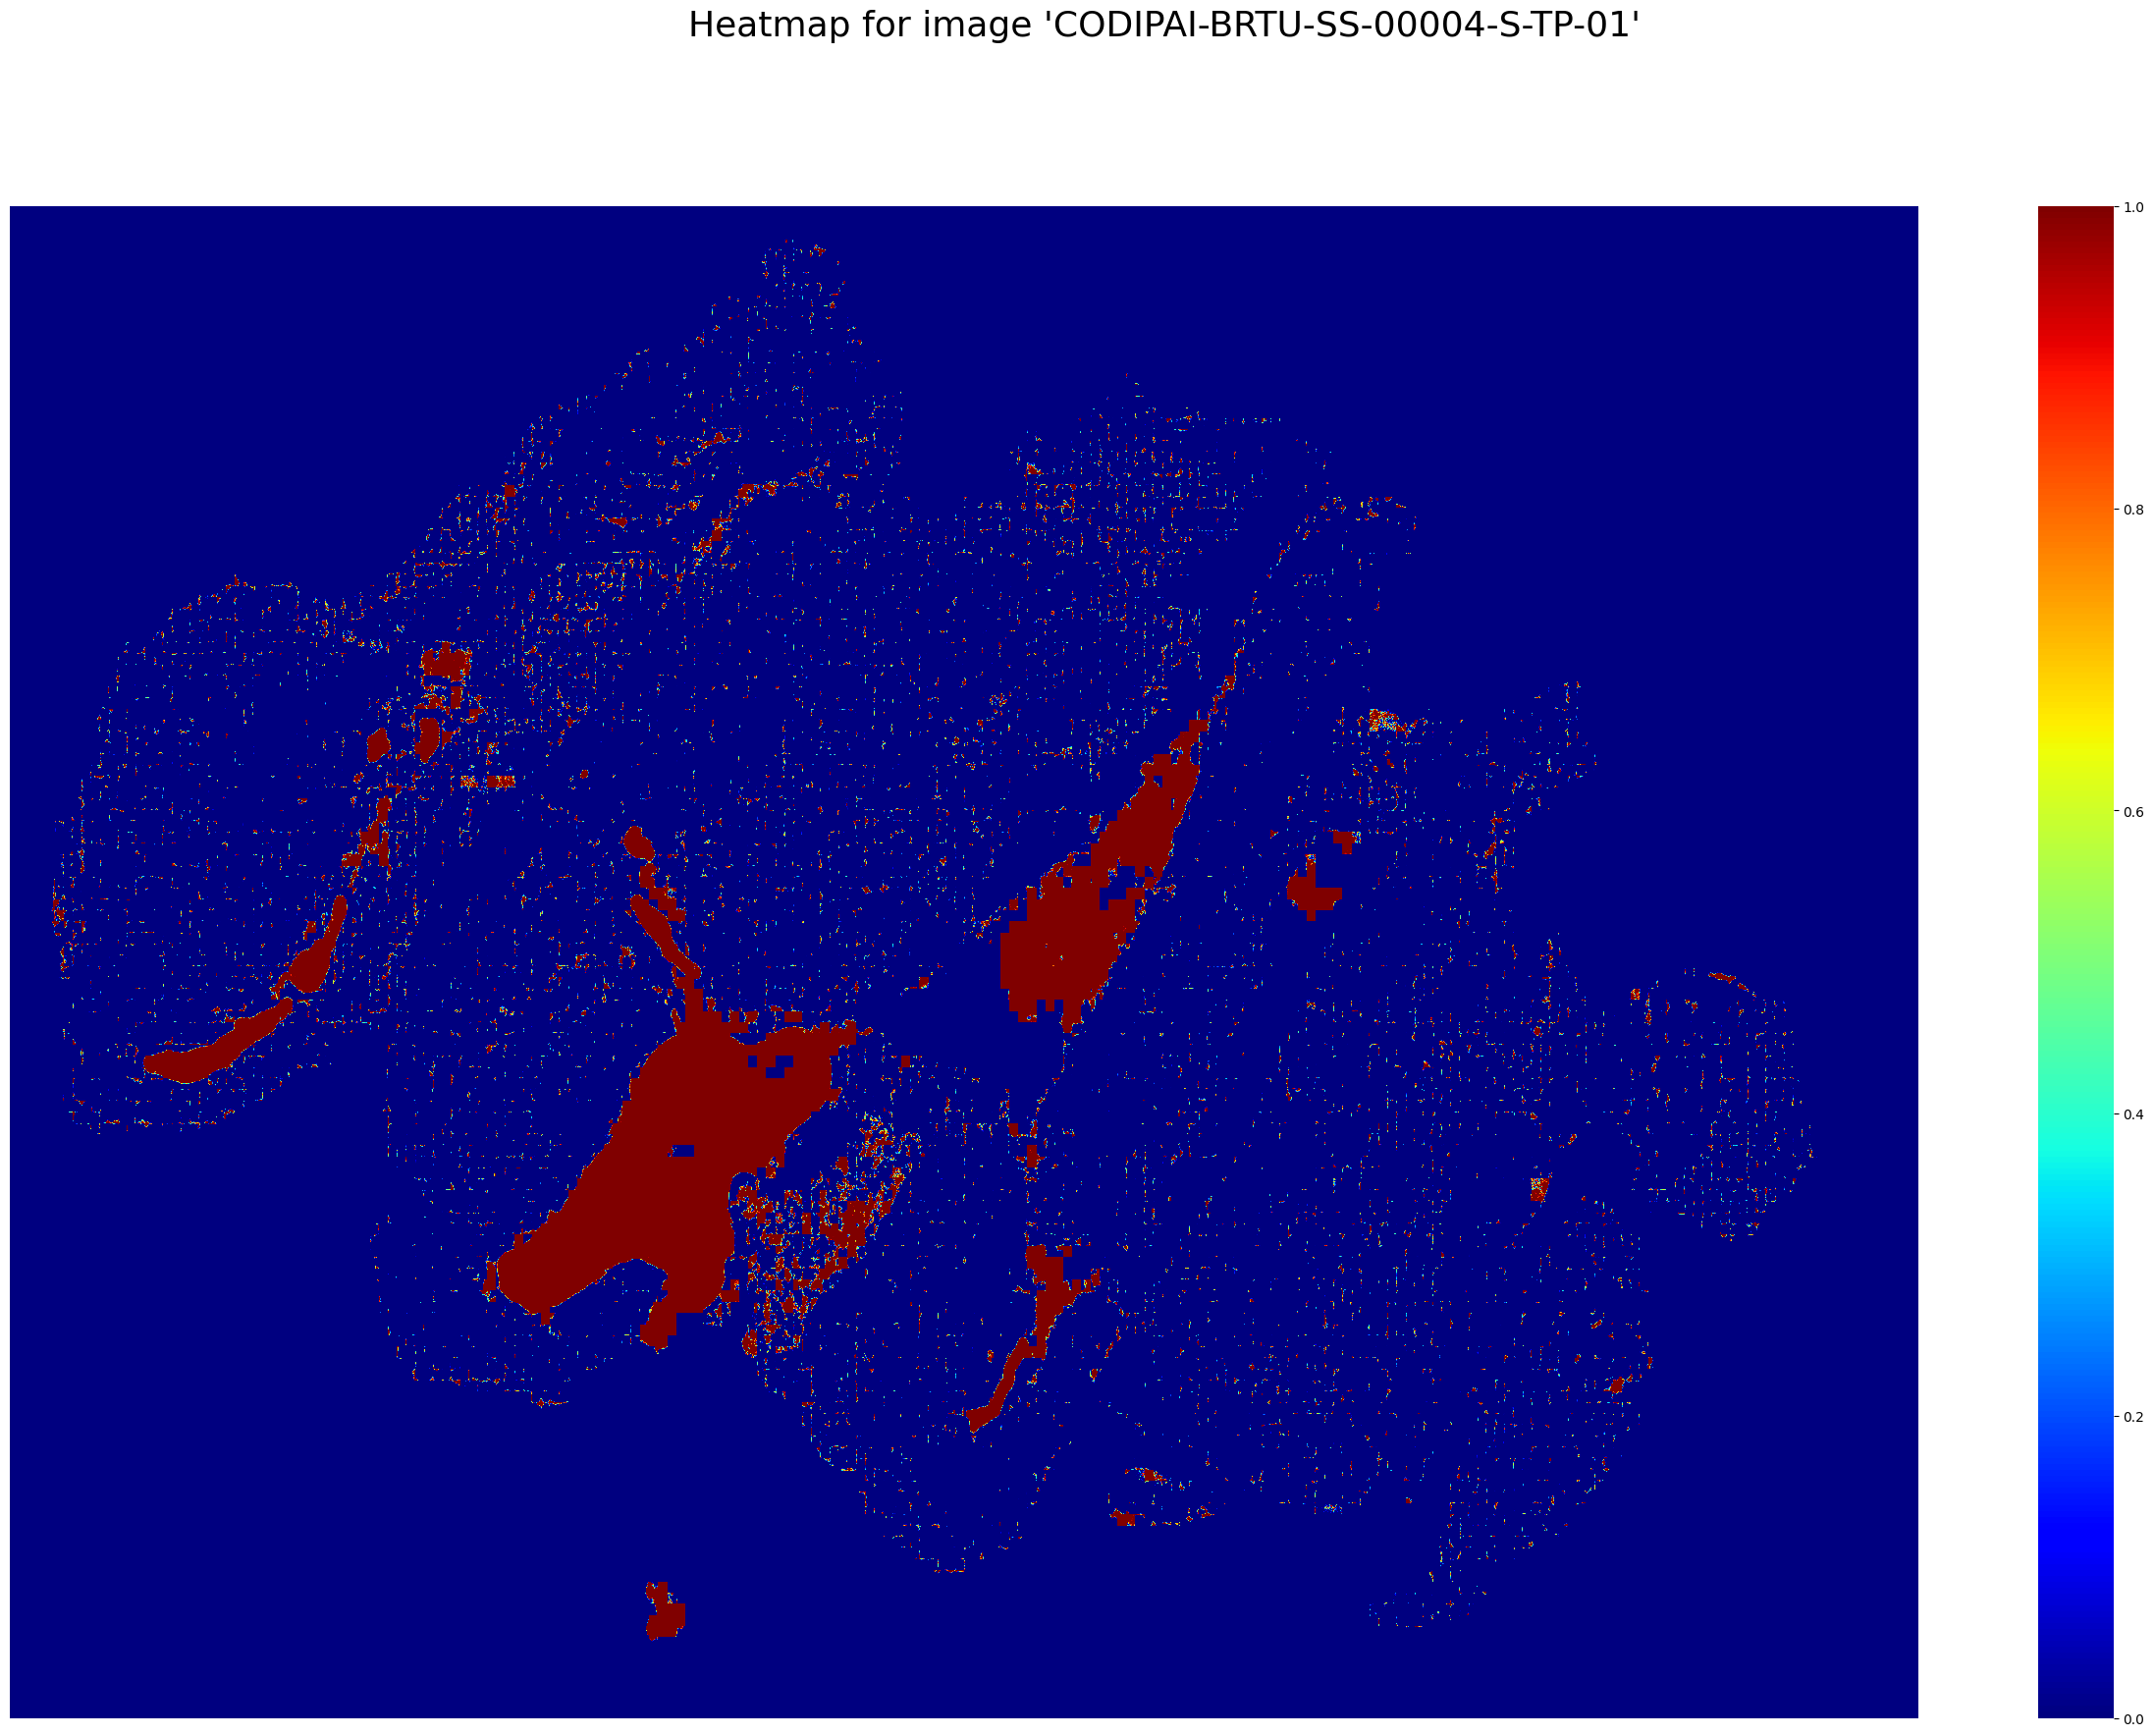

In [8]:

original_img_path = "{}/{}/{}.png".format(wsi_images_results_dir, ID, ID)
logger.info("Segmenting wsi image: '{}'".format(ID))
unet_results_dir = "{}/{}/01-unet_result".format(patch_images_results_dir, ID)

pil_original_image = load_pil_image(original_img_path, gray=False)
np_scaled_down_image = pil_to_np(pil_original_image)

# fcn roi identification
count_tiles = 0
np_heatmap = np.zeros((np_scaled_down_image.shape[0], np_scaled_down_image.shape[1]))
np_tissue_roi = np.zeros_like(np_scaled_down_image)
for _, _, unet_tile_files in sorted(os.walk(unet_results_dir)):
    for unet_tile_image_file in sorted(unet_tile_files):
        if os.path.isfile("{}/{}".format(unet_results_dir, unet_tile_image_file)):

            # load the unet image-patch result
            np_tile_unet = np.copy(pil_to_np(load_pil_image("{}/{}".format(unet_results_dir, unet_tile_image_file), gray=True)))
            np_tile_unet = np_tile_unet * (1.0/255)
            np_tile_unet[np.isnan(np_tile_unet)] = 0

            # check if exists values greather than 0.x
            if np.any(np.unique(np_tile_unet > 0.1)):

                aux_row_column = unet_tile_image_file.split("_")[-1].replace(".png", "").split('c')
                row = int(aux_row_column[0].replace("r", ""))
                column = int(aux_row_column[-1])

                r_s = row * tile_size
                r_e = r_s + tile_size
                c_s = column * tile_size
                c_e = c_s + tile_size
                np_heatmap[r_s:r_e, c_s:c_e] = image_resize(np_tile_unet, height=tile_size)

                np_tile_unet = basic_threshold(np_tile_unet, threshold=0.01, output_type="uint8")
                tissue_area = tissue_percent(np_tile_unet)
                if tissue_area > 1:

                    count_tiles += 1

                else:
                    np_heatmap[r_s:r_e, c_s:c_e] = 0

logger.info("\t '{}' tiles identified as ROI after post processing".format(count_tiles))
logger.info("-")

f = plt.figure(figsize=((np_heatmap.shape[1]*20)/np_heatmap.shape[0], 20))
f.suptitle("Heatmap for image '{}'".format(ID), fontsize=26)

ax1 = f.add_subplot(111)
sns.heatmap(np_heatmap, ax=ax1, xticklabels=False, yticklabels=False, vmin=0, vmax=1, cmap="jet", cbar=True, robust=True)

f.savefig(original_img_path.replace("{}.png".format(ID), "{}_heatmap.png".format(ID)))
utils.save_image(TF.to_tensor(np_to_pil(np_heatmap )), original_img_path.replace("{}.png".format(ID), "{}_heatmap_gray.png".format(ID)))

# Make segmention wsi image

In [9]:
import cv2
import numpy as np
img1 = cv2. imread ( './results/wsi/CODIPAI-BRTU-SS-00004-S-TP-01/CODIPAI-BRTU-SS-00004-S-TP-01.png' )
img2 = cv2. imread ( './results/wsi/CODIPAI-BRTU-SS-00004-S-TP-01/CODIPAI-BRTU-SS-00004-S-TP-01_heatmap_gray.png' )

green_hair = np.copy(img1)
green_hair[(img2==255).all(-1)] = [0,255,0]
green_hair_w = cv2.addWeighted(green_hair, 0.3, img1, 0.7, 0, green_hair)

cv2.imwrite('./results/wsi/CODIPAI-BRTU-SS-00004-S-TP-01/Segmented_img.png', green_hair_w)
cv2. waitKey ( 0 )
cv2. destroyAllWindows ()